In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [28]:
def calculate_trans_p(traj):
    """
    Calculate average trans population and standard error across multiple trajectories.

    Parameters
    ----------
    traj : np.ndarray
        A 3D array of shape (n_trajs, timesteps, residues), values are 0 (cis), 1 (trans), or NaN.

    Returns
    -------
    p_trans : np.ndarray
        Mean trans population over time per residue. Shape: (timesteps, residues)

    p_trans_std : np.ndarray
        Standard error of the mean for trans population. Shape: (timesteps, residues)
    """
    if traj.ndim != 3:
        raise ValueError(f"Expected input shape (n_trajs, timesteps, residues), got {traj.shape}")

    # Count of non-NaN entries
    n_included = np.sum(~np.isnan(traj), axis=0)  # shape: (timesteps, residues)

    # Mean trans population, ignoring NaNs
    p_trans = np.nanmean(traj, axis=0)  # shape: (timesteps, residues)

    # Standard error of the mean
    with np.errstate(invalid='ignore', divide='ignore'):
        p_trans_std = np.sqrt(np.nanvar(traj, axis=0) / (n_included - 1))
        p_trans_std[n_included <= 1] = np.nan  # Set std to NaN where not enough samples

    print('Trans population shape:', p_trans.shape)
    print('Trans population error shape:', p_trans_std.shape)

    return p_trans, p_trans_std

## The Trans Population overtime Plot

In [17]:
omega_all_state = []
state_num = 4
for i in range(state_num):
    omega_state = Data.load(f'omega_data/omega_state{i}.pkl').array_list
    omega_all_state.append(omega_state)

omega_all_state[0][0].shape # shoule be (4, 85, x, 3) shape

(7333, 3)

In [25]:
nstate = len(omega_all_state)  # should be 6
ntraj = len(omega_all_state[0])  # should be 85

all_cistrans = []

# Convert each omega trajectory into cis/trans states
for i in range(nstate):
    omega_state = omega_all_state[i]
    all_cistrans_state = []
    
    for j in range(ntraj):
        all_cistrans_state.append(omega2cistrans(omega_state[j]))  # omega_state[j] shape: (T, 3)
    
    all_cistrans.append(all_cistrans_state)

# Determine the longest trajectory length across all states and trajs
maxlength = max(
    len(all_cistrans[i][j])
    for i in range(nstate)
    for j in range(ntraj)
)
print('maxlength', maxlength)

# Preallocate array with NaNs: shape (nstate, ntraj, maxlength, 3)
all_traj = np.full((nstate, ntraj, maxlength, 3), np.nan)

# Fill in the cis/trans values
for i in range(nstate):
    for j in range(ntraj):
        traj_len = len(all_cistrans[i][j])
        all_traj[i, j, :traj_len, :] = all_cistrans[i][j]

all_traj.shape

maxlength 9835


(4, 85, 9835, 3)

In [31]:
trans_all_population = []
trans_all_population_err = []
state_num = 4

for state in range(state_num):
    traj = all_traj[state]
    trans_population, trans_population_err = calculate_trans_p(traj)
    
    trans_all_population.append(trans_population)
    trans_all_population_err.append(trans_population_err)

trans_all_population = np.array(trans_all_population)
trans_all_population_err = np.array(trans_all_population_err)

print('trans_all_population.shape', trans_all_population.shape)
print('trans_all_population_err.shape', trans_all_population_err.shape)

Trans population shape: (9835, 3)
Trans population error shape: (9835, 3)
Trans population shape: (9835, 3)
Trans population error shape: (9835, 3)
Trans population shape: (9835, 3)
Trans population error shape: (9835, 3)
Trans population shape: (9835, 3)
Trans population error shape: (9835, 3)
trans_all_population.shape (4, 9835, 3)
trans_all_population_err.shape (4, 9835, 3)


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_81377/1131375139.py:25: RuntimeWarning: Mean of empty slice
  p_trans = np.nanmean(traj, axis=0)  # shape: (timesteps, residues)
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_81377/1131375139.py:29: RuntimeWarning: Degrees of freedom <= 0 for slice.
  p_trans_std = np.sqrt(np.nanvar(traj, axis=0) / (n_included - 1))


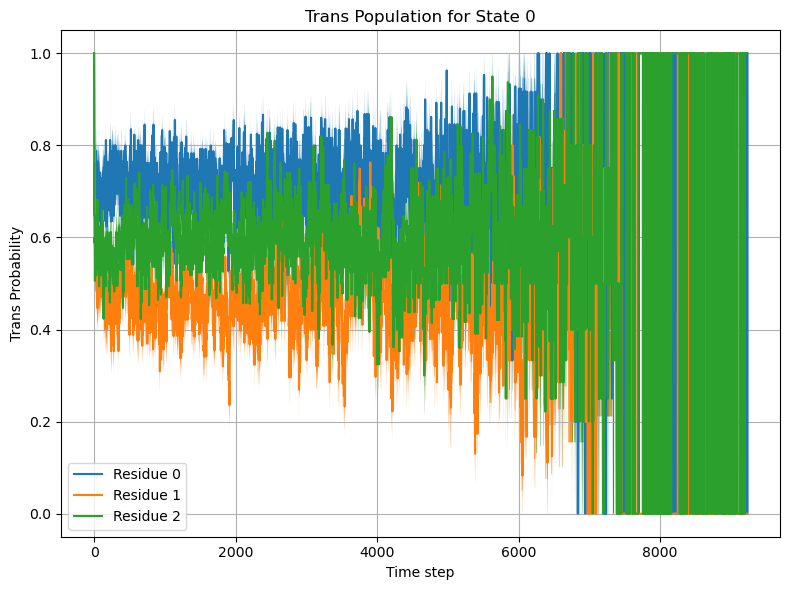

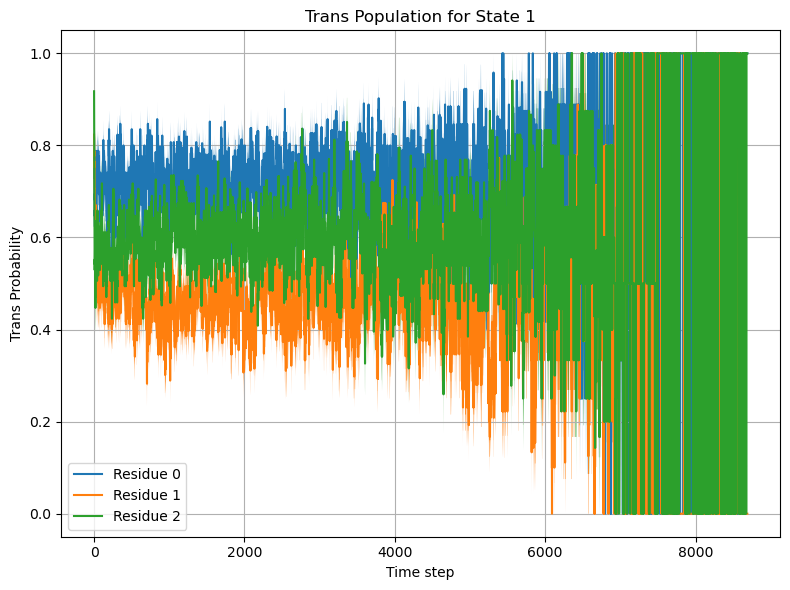

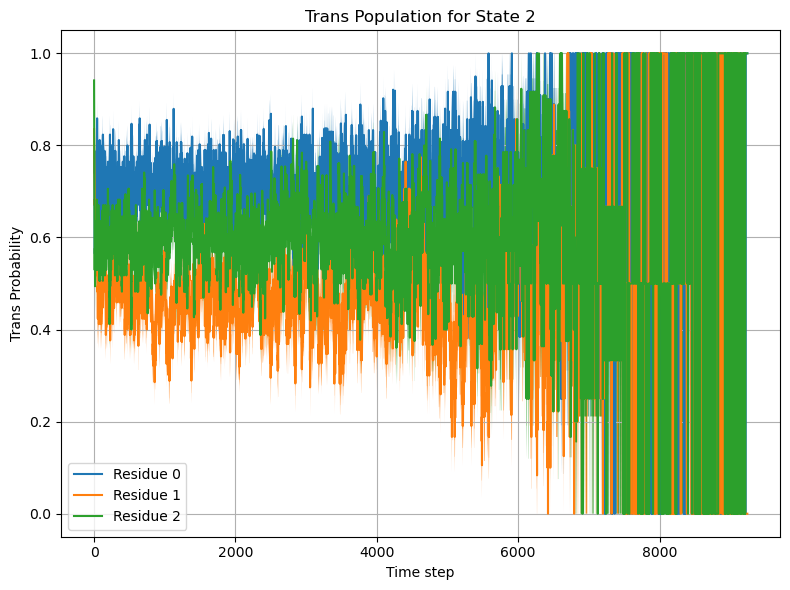

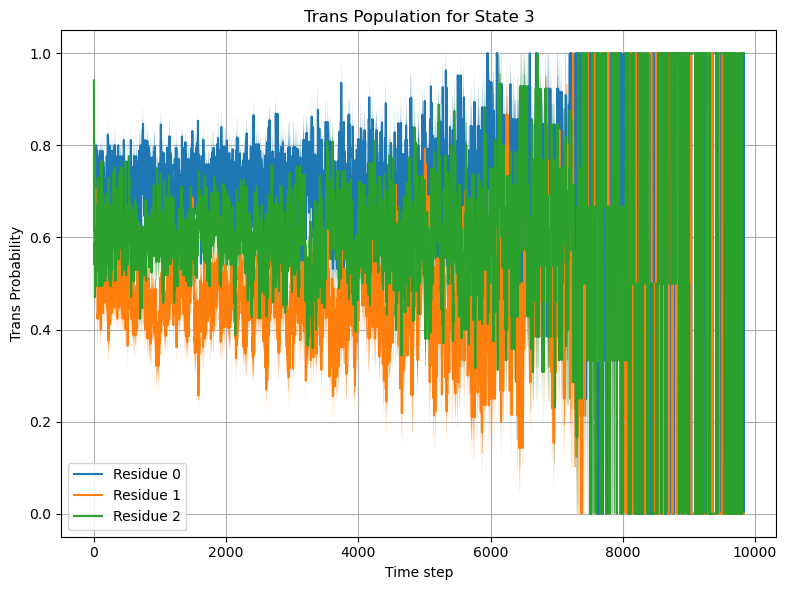

In [32]:
state_num = 4

for state_index in range(state_num):  # Loop over 6 states
    plt.figure(figsize=(8, 6))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x, y, label=f'Residue {residue_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


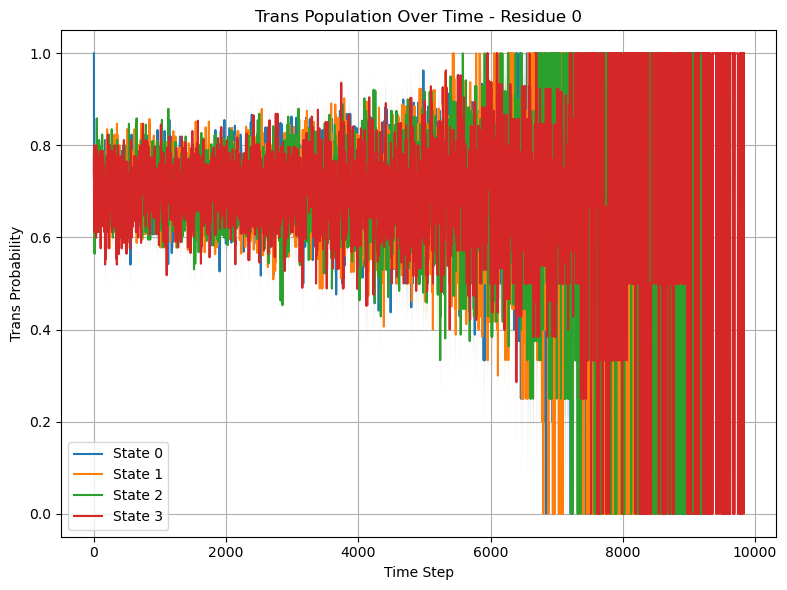

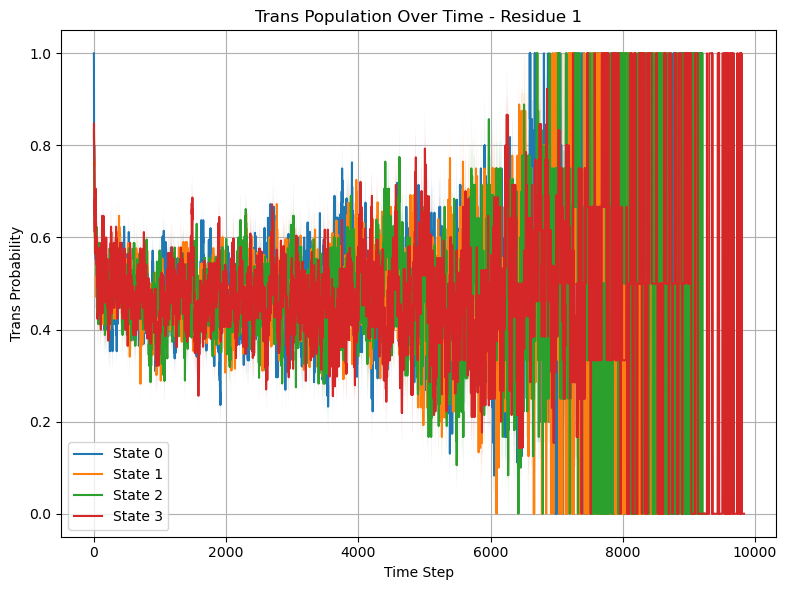

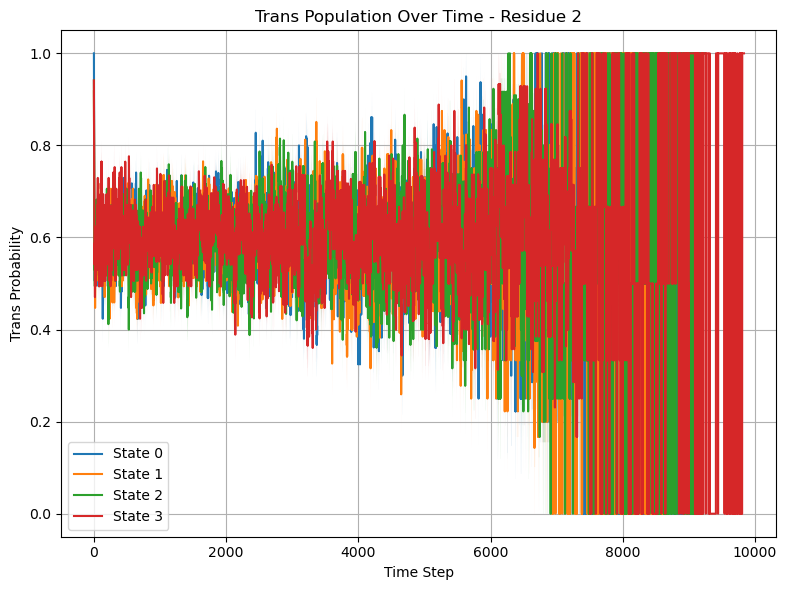

In [35]:
state_num = 4

for residue_index in range(3):  # 3 residues
    plt.figure(figsize=(8, 6))

    for state_index in range(state_num):  # 6 states
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use lagtimes or time array if available

        plt.plot(x, y, label=f'State {state_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    plt.title(f'Trans Population Over Time - Residue {residue_index}')
    plt.xlabel('Time Step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    #plt.ylim(0.4, 0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Error Over Times

In [36]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_array.shape
trans_refer_array

array([[0.70688719, 0.46790174, 0.60037703],
       [0.70139436, 0.46283815, 0.60226711],
       [0.70286182, 0.46293759, 0.60497662],
       [0.70082735, 0.45620934, 0.60761331]])

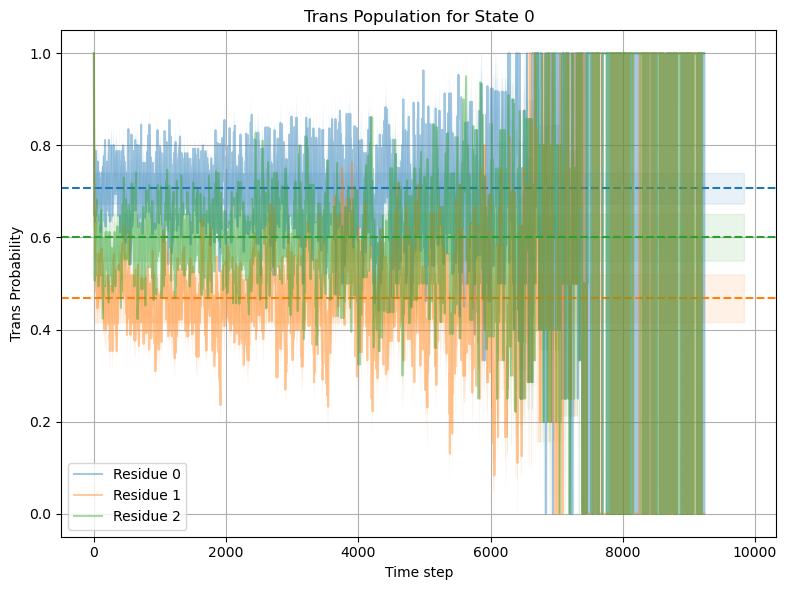

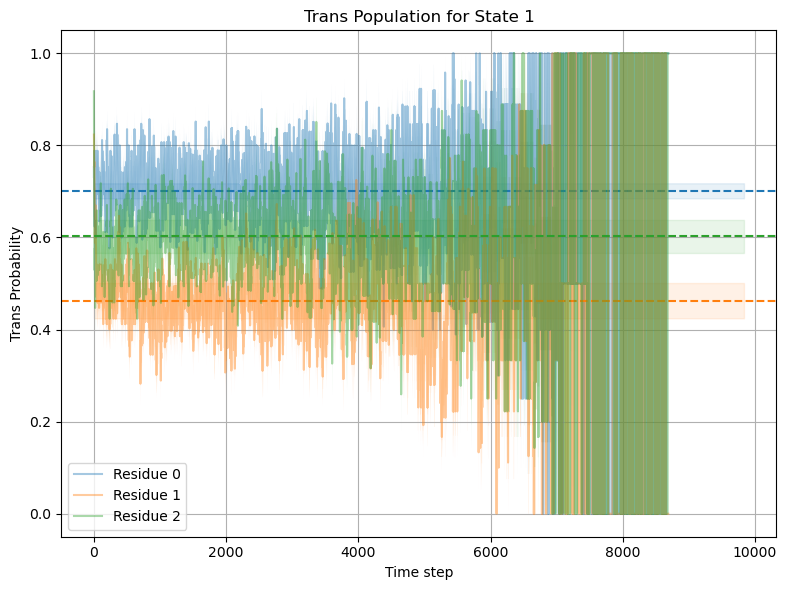

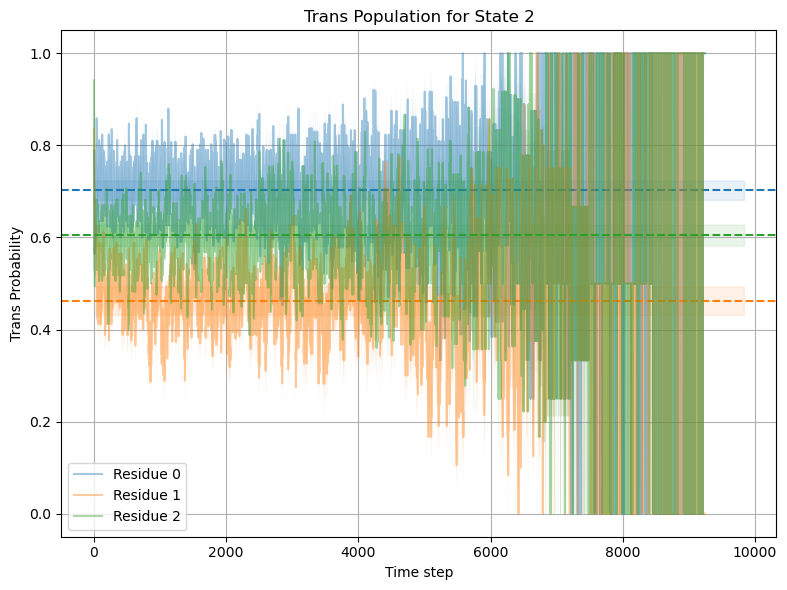

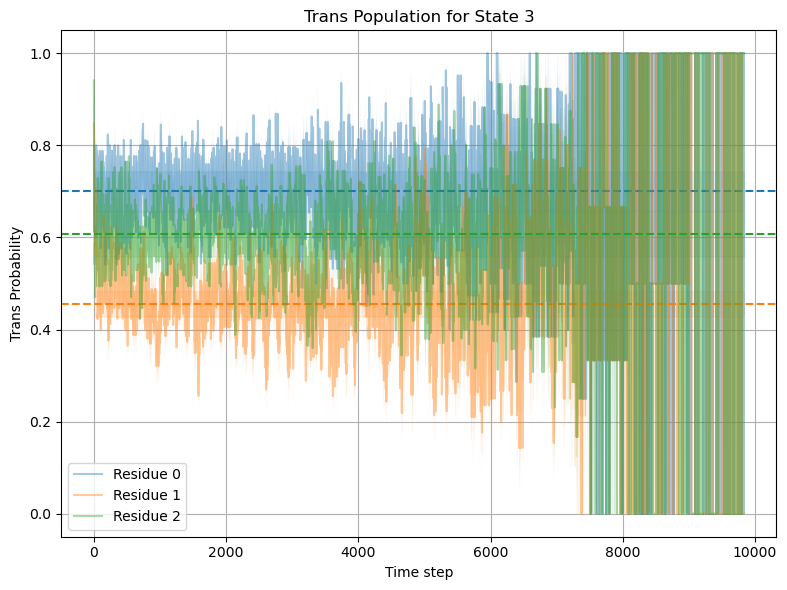

In [42]:
state_num = 4

for state_index in range(state_num):  # Loop over 6 states
    plt.figure(figsize=(8, 6))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use actual time values

        # Time-dependent population
        plt.plot(x, y, label=f'Residue {residue_index}', alpha=0.4)
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference horizontal line
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=1)
        plt.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{residue_index}', alpha=0.1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


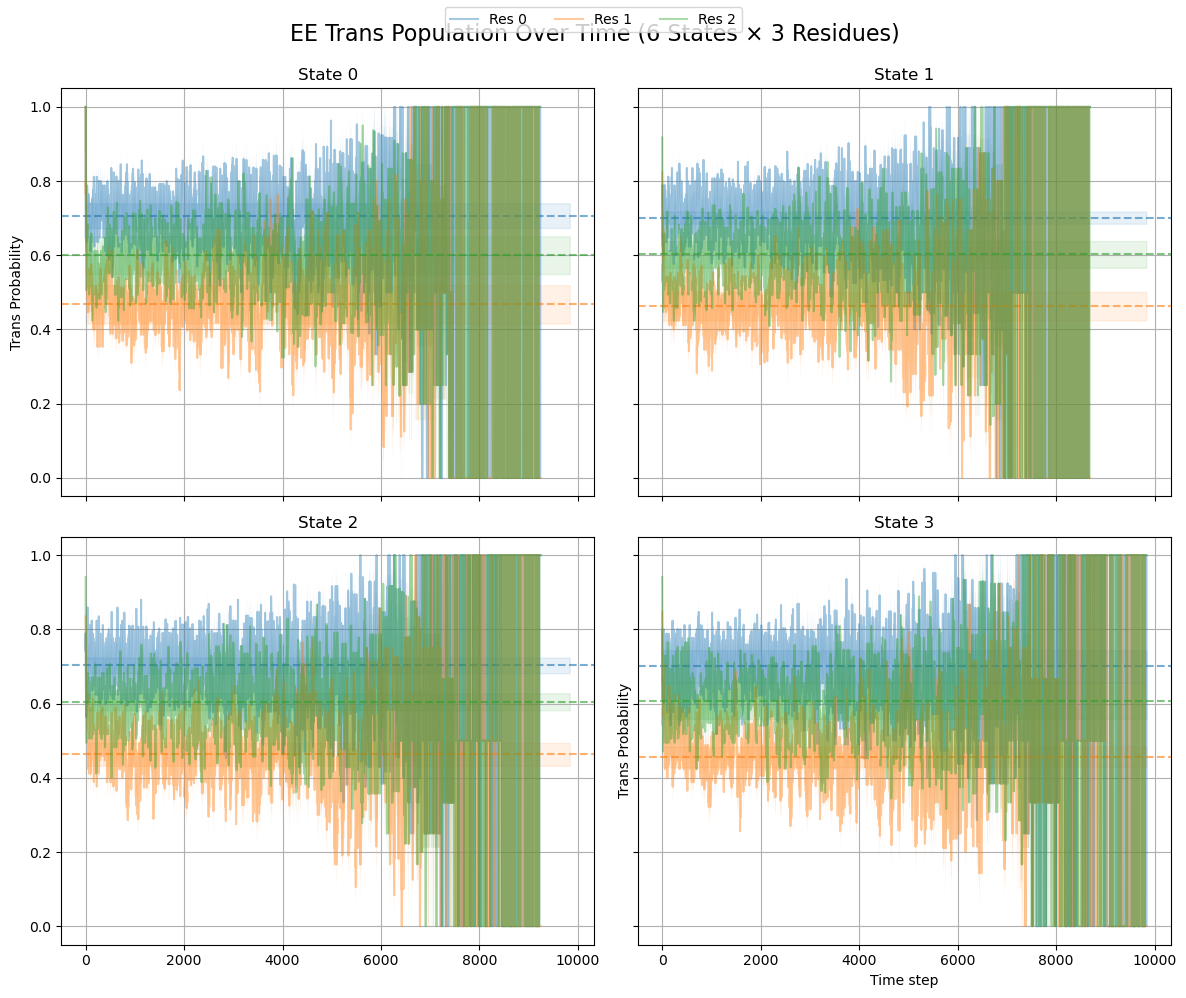

In [54]:
state_num = 4

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index 0 through 5

for state_index in range(state_num):  # 6 states → 2x3 grid
    ax = axes[state_index]
    
    for residue_index in range(3):  # 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use time array if available

        # Time-dependent curve
        ax.plot(x, y, label=f'Res {residue_index}', alpha=0.4)
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference line and shaded error
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]
        ax.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        ax.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{residue_index}', alpha=0.1)

    ax.set_title(f'State {state_index}')
    ax.grid(True)
    if state_index >= 3:
        ax.set_xlabel('Time step')
    if state_index % 3 == 0:
        ax.set_ylabel('Trans Probability')

# Shared legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)

plt.suptitle("EE Trans Population Over Time (6 States × 3 Residues)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


### Plot the ERROR

In [47]:
errors_all = []
errors_err_all = []


for res in range(3):
    # Broadcast reference to (6, 600030)
    reference = trans_refer_array[:, res][:, np.newaxis]
    reference_err = trans_refer_err_array[:, res][:, np.newaxis]

    # Compute differences and propagated error
    errors = trans_all_population[:, :, res] - reference
    errors_err = np.sqrt(
        trans_all_population_err[:, :, res]**2 + reference_err**2
    )

    errors_all.append(errors)
    errors_err_all.append(errors_err)

    #plt.plot(errors)
    #plt.show()

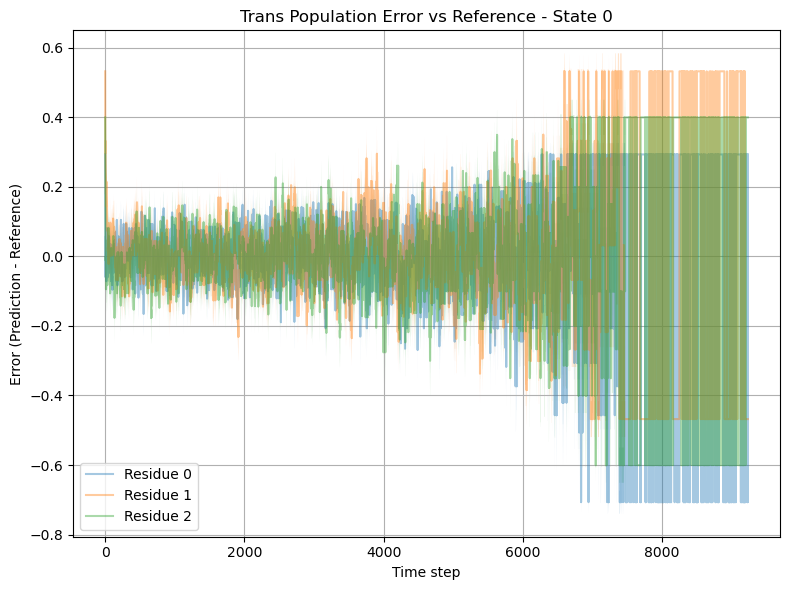

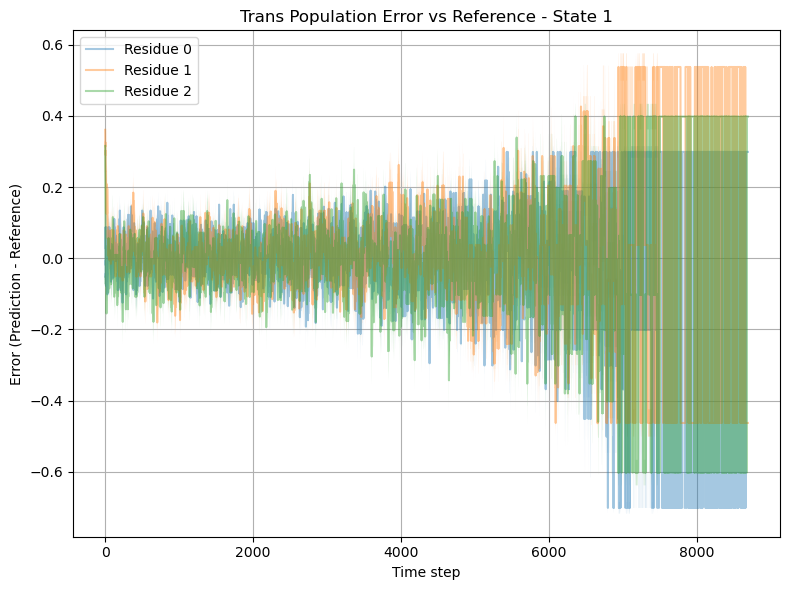

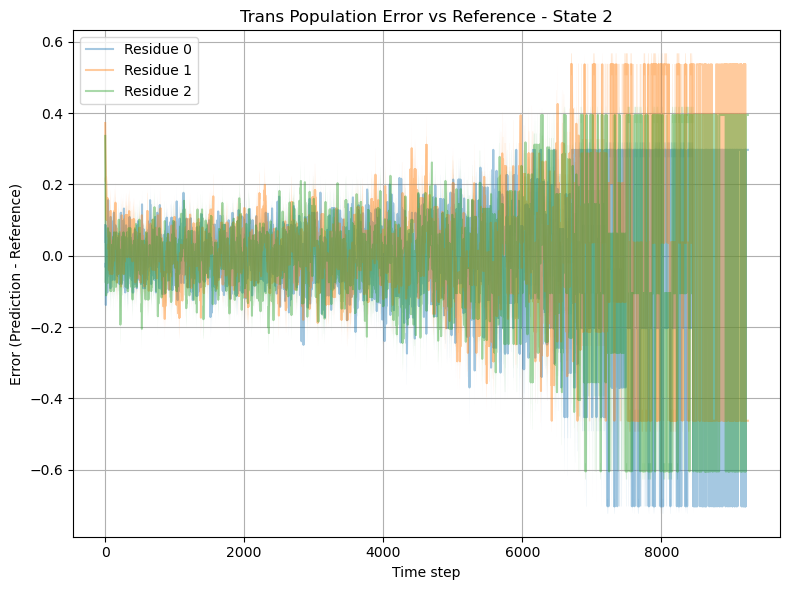

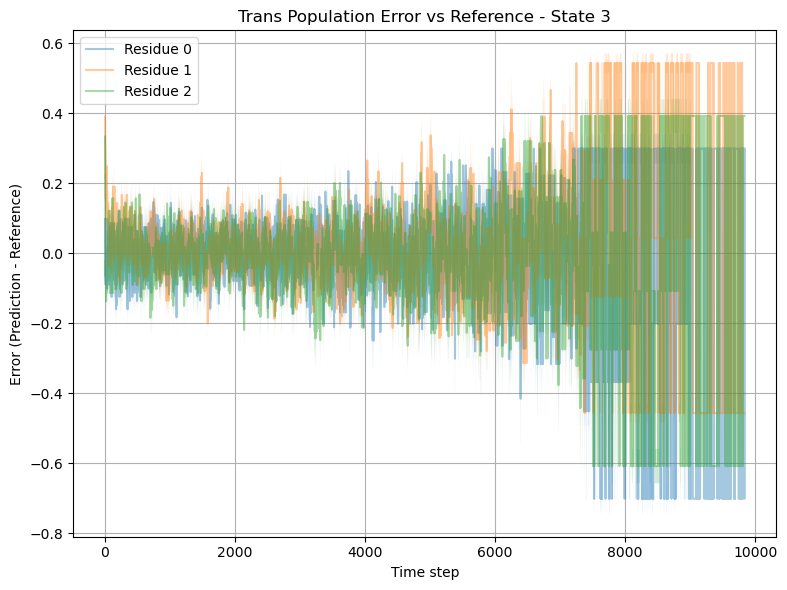

In [50]:
state_num = 4

for state_index in range(state_num):  # Loop over 6 states
    plt.figure(figsize=(8, 6))
    
    x = np.arange(trans_all_population.shape[1])  # Time axis, e.g., 600030

    for residue_index in range(3):  # Loop over 3 residues
        error = trans_all_population[state_index, :, residue_index] - trans_refer_array[state_index, residue_index]
        
        error_err = np.sqrt(
            trans_all_population_err[state_index, :, residue_index] ** 2 +
            trans_refer_err_array[state_index, residue_index] ** 2  # ✅ square this too
        )

        plt.plot(x, error, label=f'Residue {residue_index}', alpha=0.4)
        plt.fill_between(x, error - error_err, error + error_err, alpha=0.2)

    plt.title(f'Trans Population Error vs Reference - State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    #plt.ylim(-0.1, 0.1)
    plt.tight_layout()
    plt.show()


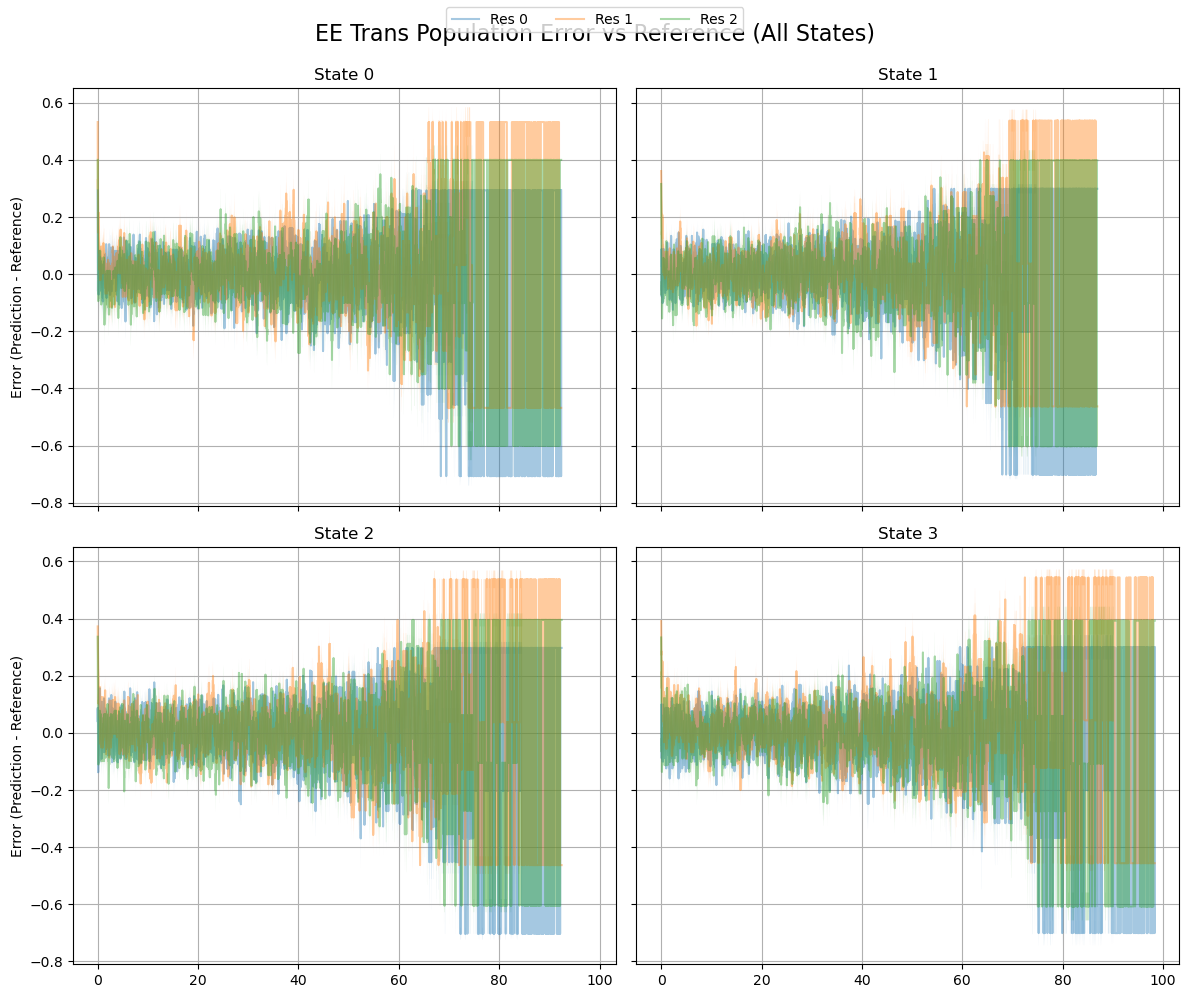

In [55]:
dt_in_ns = 0.01
state_num = 4

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

x = np.arange(trans_all_population.shape[1])  # Time axis

for state_index in range(state_num):
    ax = axes[state_index]

    for residue_index in range(3):
        error = trans_all_population[state_index, :, residue_index] - trans_refer_array[state_index, residue_index]
        
        error_err = np.sqrt(
            trans_all_population_err[state_index, :, residue_index]**2 +
            trans_refer_err_array[state_index, residue_index]**2
        )

        ax.plot(x * dt_in_ns, error, label=f'Res {residue_index}', alpha=0.4)
        ax.fill_between(x * dt_in_ns, error - error_err, error + error_err, alpha=0.2)

    ax.set_title(f'State {state_index}')
    ax.grid(True)
    if state_index // 2 == 2:
        ax.set_xlabel('Time ns')
    if state_index % 2 == 0:
        ax.set_ylabel('Error (Prediction - Reference)')

# Add a global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)
fig.suptitle("EE Trans Population Error vs Reference (All States)", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.ylim(-0.05, 0.05)  # Or any range you like
plt.show()
